# Import Library

In [ ]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

# Path Directory

In [ ]:
target_path = "./Images/Object.png"
data_folder = "./Images/Data/"

# Preprocessing Function

In [ ]:
def preprocess_v1(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    eq = cv2.equalizeHist(gray)
    blur_img = cv2.medianBlur(eq, 5)
    return blur_img

def preprocess_v2(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    eq = cv2.equalizeHist(gray)
    gaussian_blur_img = cv2.GaussianBlur(eq, (3,3 ), 0)
    return gaussian_blur_img

# Find Best Match Function

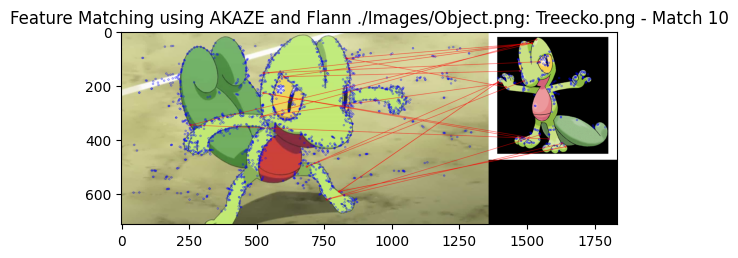

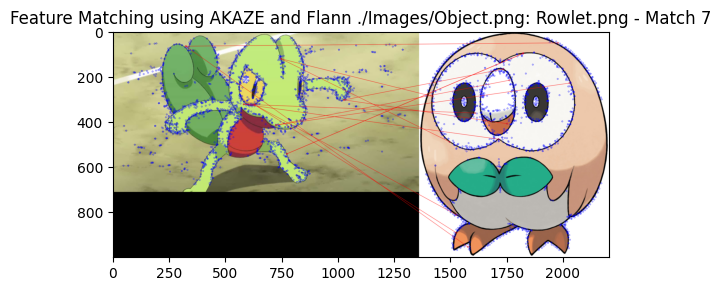

In [ ]:
def find_best_matches(pre_func, target_path, data_path, desc_alg="SIFT"):
    
    target_img = cv2.imread(target_path)
    target_img = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)
    target_gray = pre_func(target_img)

    if desc_alg == "AKAZE":
        descriptor = cv2.AKAZE.create()
    elif desc_alg == "SIFT":
        descriptor = cv2.SIFT.create()
    elif desc_alg == "ORB":
        descriptor = cv2.ORB.create()

    target_keypoints, target_desc = descriptor.detectAndCompute(target_gray, None)

    FLANN_INDEX_KDTREE = 1
    
    if desc_alg != "ORB":
        index_params = dict(algorithm=1, tree=5)
        search_params = dict(check=50)

        matcher = cv2.FlannBasedMatcher(index_params, search_params)
        target_desc = np.float32(target_desc)
    else:
        matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)

    best_match = 0
    best_match_data = {}
    
    for img_path in os.listdir(data_path):
        
        img = cv2.imread(data_path + img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_gray = pre_func(img)

        img_keypoints, img_desc = descriptor.detectAndCompute(img_gray, None)

        if desc_alg != "ORB":
            img_desc = np.float32(img_desc)

        matches = matcher.knnMatch(target_desc, img_desc, k=2)
        matches_mask = [[0, 0] for _ in range(len(matches))]

        curr_match = 0

        for i, (m, n) in enumerate(matches):
            if m.distance < 0.7 * n.distance:
                curr_match += 1
                matches_mask[i] = [1, 1]
        
        if curr_match > best_match:
            best_match = curr_match
            best_match_data = {
                "image": img,
                "image_path": img_path,
                "keypoints": img_keypoints,
                "desc": img_desc,
                "matches": matches,
                "best_match": best_match,
                "matches_mask": matches_mask
            }

    result = cv2.drawMatchesKnn(
        target_img, target_keypoints,
        best_match_data["image"], best_match_data["keypoints"],
        best_match_data["matches"], None,
        matchColor=[255, 0, 0],
        singlePointColor=[0, 0, 255],
        matchesMask=best_match_data["matches_mask"]
    )

    plt.figure()
    plt.imshow(result)
    plt.title(f"Feature Matching using {desc_alg} and {"Flann" if desc_alg != "ORB" else "BFMatcher"} {target_path}: {best_match_data["image_path"]} - Match {best_match_data["best_match"]}")
    plt.show()

find_best_matches(preprocess_v1, "./Images/Object.png", "./Images/Data/", "AKAZE")

find_best_matches(preprocess_v2, "./Images/Object.png", "./Images/Data/", "AKAZE")